## Autoregressive Models

In [29]:
import warnings

import matplotlib.pyplot as plt 
import pandas as pd
import plotly.express as px 
from pymongo import MongoClient
from sklearn.metrics import  mean_absolute_error
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg

warnings.simplefilter(action="ignore", category=FutureWarning)

#### Prepare Data

Import

In [ ]:
client = MongoClient(host="localhost", port=27017)
db = client["air-quality"]
nairobi = db["nairobi"]

The Wrangle function to import data:

In [ ]:
def wrangle(collection):
    results = collection.find(
        {"metadata.site": 29, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )

    # Read data into DataFrame
    df = pd.DataFrame(list(results)).set_index("timestamp")

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

    # Remove outliers
    df = df[df["P2"] < 500]

    # Resample to 1hr window
    y = df["P2"].resample("1H").mean().fillna(method='ffill')

    return y

In [15]:
y = pd.read_csv("data/nairobi-city-air-quality.csv").set_index("timestamp")
y.head()

,P2
timestamp,
00:02.5,34.43
05:03.9,30.53
10:04.4,22.80
15:04.2,13.30
20:04.9,16.57


In [16]:
y = y[y["P2"] < 500]

In [19]:
y.dropna(inplace=True)

An ACF plot for the data in y:

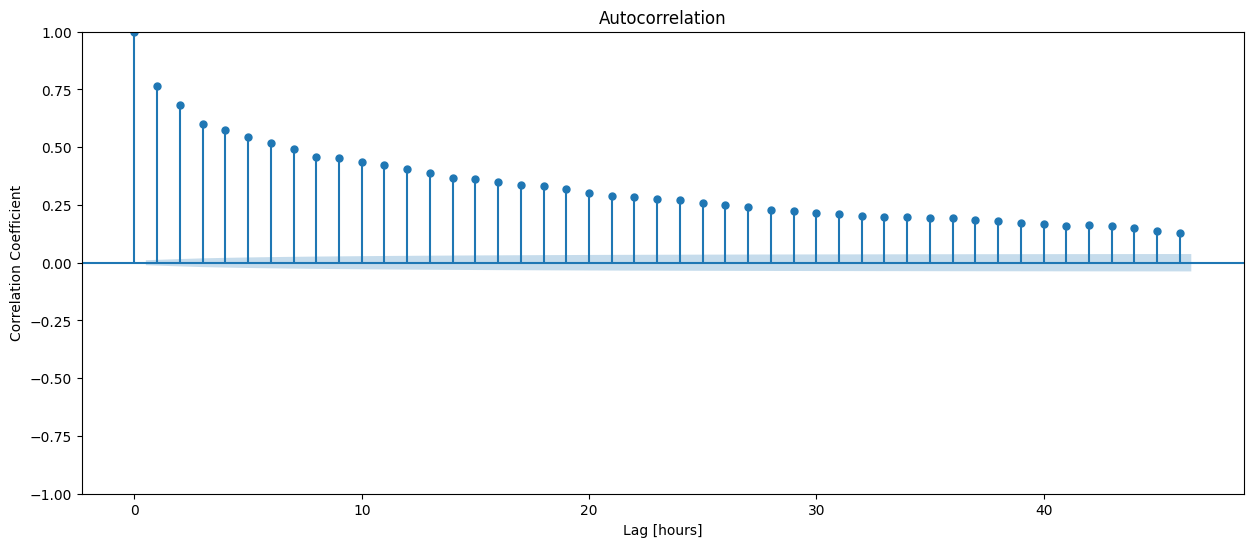

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

PACF plot for the data in y:

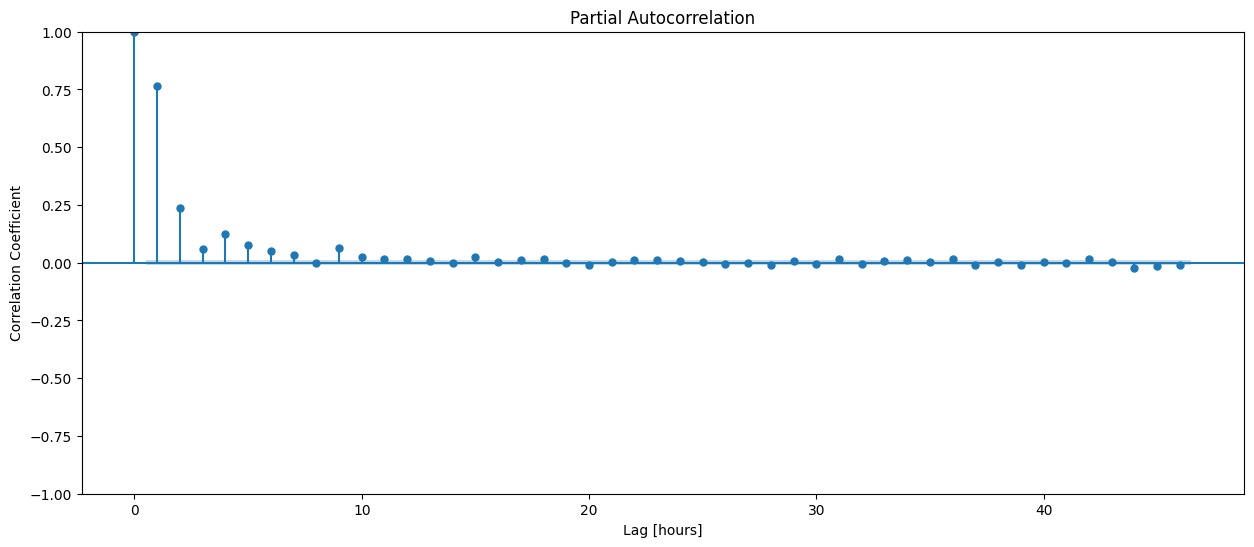

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

Train-Test Split: The first 95% of the data will be in teh training set, and the remaining 5% on the testing set.

In [24]:
cutoff_test = int(len(y)*.95)

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

In [26]:
len(y_test), len(y_train)

(1646, 31260)

In [27]:
assert len(y_test) + len(y_train) == len(y)

#### Build Model

Baseline Model:

In [30]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: P2    9.23
dtype: float64
Baseline MAE: 4.09
